In [213]:
!pip install "dask[complete]"
!pip install dask-geopandas

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/usr/lib/python3/dist-packages/secretstorage/util.py:19: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes


In [298]:
import pandas as pd
import numpy as np
import geopandas as gpd
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
%matplotlib inline

from tqdm import tqdm_notebook

import dask
import dask.dataframe as dd
import dask_geopandas

import statsmodels.api as spi

from datetime import datetime as dt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [215]:
home_twt= pd.read_csv(os.path.join('data','TWT', 'mapped', 'home_TWT.csv'), index_col=0, )

In [216]:
home_twt.head()

,user_id,home_ma
61274,884187661216268288,29067
19846,223108098,31060
65567,1183042992820633600,28903
61632,912960710245847040,08904
13247,144996365,29067


In [217]:
home_twt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7765 entries, 61274 to 56849
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  7765 non-null   int64 
 1   home_ma  7765 non-null   object
dtypes: int64(1), object(1)
memory usage: 182.0+ KB


In [218]:
target_users= home_twt['user_id'].tolist()

In [219]:
import datetime
e_date = datetime.datetime.strptime('2021-04-30', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

from datetime import date, timedelta

delta = e_date - i_date       # as timedelta

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

min_ndays = len(target_days)

In [220]:
def read_tweets(target_days):
    twt_gdfs=[]
    for d in tqdm_notebook(target_days):
        day_for_file= d.strftime('%Y-%m-%d')

        try:
            twt_gdf= gpd.read_file(os.path.join("data","TWT","mapped", "map_point_tweets_{}.geojson".format(day_for_file)), 
                                   driver='GeoJSON', 
                                   encoding='utf-8',
                                  parse_dates=['timestamp'])
            twt_gdfs.append(twt_gdf)
        except:
            print("No file found for points: {}".format(day_for_file))

        try:
            twt_gdf= gpd.read_file(os.path.join("data", "TWT", "mapped", "map_poly_tweets_{}.geojson".format(day_for_file)), 
                                   driver='GeoJSON', 
                                   encoding='utf-8',
                                  parse_dates=['timestamp'])
            twt_gdfs.append(twt_gdf)
        except:
            print("No file found for polygon: {}".format(day_for_file))

    twt_gdf = pd.concat(twt_gdfs, ignore_index=True)
    twt_gdf['timestamp']= pd.to_datetime(twt_gdf['timestamp'])
    twt_gdf['date']= twt_gdf['timestamp'].apply(lambda x: x.date())
    return twt_gdf

In [221]:
twt_gdf = read_tweets(target_days)

  0%|          | 0/395 [00:00<?, ?it/s]

No file found for points: 2020-04-08
No file found for polygon: 2020-04-08
No file found for points: 2020-08-06
No file found for polygon: 2020-08-06
No file found for points: 2020-08-11
No file found for polygon: 2020-08-11
No file found for points: 2020-08-18
No file found for polygon: 2020-08-18
No file found for points: 2020-09-23
No file found for polygon: 2020-09-23
No file found for points: 2020-10-03
No file found for polygon: 2020-10-03
No file found for points: 2020-10-09
No file found for polygon: 2020-10-09
No file found for points: 2020-10-21
No file found for polygon: 2020-10-21
No file found for points: 2020-10-23
No file found for polygon: 2020-10-23
No file found for points: 2020-10-28
No file found for polygon: 2020-10-28
No file found for points: 2020-11-08
No file found for polygon: 2020-11-08
No file found for points: 2020-11-17
No file found for polygon: 2020-11-17
No file found for points: 2020-11-21
No file found for polygon: 2020-11-21
No file found for points:

In [222]:
twt_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 5598483 entries, 0 to 5598482
Data columns (total 9 columns):
 #   Column       Dtype              
---  ------       -----              
 0   tw_id        int64              
 1   user_id      int64              
 2   timestamp    datetime64[ns, UTC]
 3   primary_key  object             
 4   geometry     geometry           
 5   place_name   object             
 6   place_type   object             
 7   Shape_area   float64            
 8   date         object             
dtypes: datetime64[ns, UTC](1), float64(1), geometry(1), int64(2), object(4)
memory usage: 384.4+ MB


In [223]:
twt_gdf= twt_gdf[twt_gdf['user_id'].isin(target_users)]

In [224]:
twt_w_home = twt_gdf.merge(home_twt, on='user_id')

In [225]:
twt_w_home.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2345000 entries, 0 to 2344999
Data columns (total 10 columns):
 #   Column       Dtype              
---  ------       -----              
 0   tw_id        int64              
 1   user_id      int64              
 2   timestamp    datetime64[ns, UTC]
 3   primary_key  object             
 4   geometry     geometry           
 5   place_name   object             
 6   place_type   object             
 7   Shape_area   float64            
 8   date         object             
 9   home_ma      object             
dtypes: datetime64[ns, UTC](1), float64(1), geometry(1), int64(2), object(5)
memory usage: 196.8+ MB


In [226]:
twt_w_home.head()

,tw_id,user_id,timestamp,primary_key,geometry,place_name,place_type,Shape_area,date,home_ma
0,1245274706393038849,709417970347466754,2020-04-01 09:00:00+00:00,08147,POINT (1.89248 41.54520),NaN,NaN,NaN,2020-04-01,08019
1,1245214311036989440,709417970347466754,2020-04-01 05:00:01+00:00,08019,POINT (2.18260 41.38326),NaN,NaN,NaN,2020-04-01,08019
2,1245425704847790080,709417970347466754,2020-04-01 19:00:01+00:00,08019,POINT (2.13220 41.38159),NaN,NaN,NaN,2020-04-01,08019
3,1245123711847538695,709417970347466754,2020-03-31 23:00:00+00:00,08200,POINT (2.03230 41.34948),NaN,NaN,NaN,2020-03-31,08019
4,1245486099692163072,709417970347466754,2020-04-01 23:00:00+00:00,08121,POINT (2.43787 41.53394),NaN,NaN,NaN,2020-04-01,08019


Save results

In [227]:
twt_w_home['timestamp']= twt_w_home['timestamp'].astype(str)
twt_w_home_df= pd.DataFrame(twt_w_home)
twt_w_home_df.to_csv(os.path.join('data','TWT', 'twt_w_home.csv'))

In [228]:
twt_w_home_df= pd.read_csv(os.path.join('data','TWT', 'twt_w_home.csv'), index_col=0)
twt_w_home_df = twt_w_home_df.drop(columns='geometry place_name place_type Shape_area timestamp'.split())
twt_w_home_df.head()

,tw_id,user_id,primary_key,date,home_ma
0,1245274706393038849,709417970347466754,08147,2020-04-01,08019
1,1245214311036989440,709417970347466754,08019,2020-04-01,08019
2,1245425704847790080,709417970347466754,08019,2020-04-01,08019
3,1245123711847538695,709417970347466754,08200,2020-03-31,08019
4,1245486099692163072,709417970347466754,08121,2020-04-01,08019


In [229]:
twt_w_home_df.to_csv(os.path.join('data','TWT', 'twt_w_home_reduced.csv'))

-----------------------------------------------------------

### We can start from here 

In [230]:
twt_w_home_df= pd.read_csv(os.path.join('data','TWT', 'twt_w_home_reduced.csv'), dtype={'home_ma': 'str', 'primary_key':'str'}, index_col=0)
twt_w_home_df['home_ma']= twt_w_home_df['home_ma'].apply(lambda x: x.zfill(5))

In [231]:
twt_w_home_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345000 entries, 0 to 2344999
Data columns (total 5 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   tw_id        int64 
 1   user_id      int64 
 2   primary_key  object
 3   date         object
 4   home_ma      object
dtypes: int64(2), object(3)
memory usage: 107.3+ MB


In [232]:
single_ma_pairs= twt_w_home_df.drop_duplicates(['primary_key', 'home_ma'])
single_ma_pairs.head()

,tw_id,user_id,primary_key,date,home_ma
0,1245274706393038849,709417970347466754,08147,2020-04-01,08019
1,1245214311036989440,709417970347466754,08019,2020-04-01,08019
3,1245123711847538695,709417970347466754,08200,2020-03-31,08019
4,1245486099692163072,709417970347466754,08121,2020-04-01,08019
5,1245380404812619778,709417970347466754,43171,2020-04-01,08019


In [233]:
census_zones_gdf = gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')
census_zones_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803..."
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42..."
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362..."
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42..."
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658..."


In [234]:
census_zones_gdf[census_zones_gdf['primary_key']=='08904']

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry
397,08904,0.932,11.0,0.0,0.0,13415,6568,6847,11.802575,0.0,0.0,"POLYGON ((2.12000 41.50770, 2.12303 41.50552, ..."


In [235]:
def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

def distance_between_ma(r1, r2):
    lon2= census_zones_gdf[census_zones_gdf['primary_key']==r2]['geometry'].values[0].centroid.x
    lat2= census_zones_gdf[census_zones_gdf['primary_key']==r2]['geometry'].values[0].centroid.y
    
    lon1= census_zones_gdf[census_zones_gdf['primary_key']==r1]['geometry'].values[0].centroid.x
    lat1= census_zones_gdf[census_zones_gdf['primary_key']==r1]['geometry'].values[0].centroid.y

    d = haversine_np(lon1, lat1, lon2, lat2)
    return d

    
def generate_distance_matrix(df):
    node_names = pd.unique(df[['primary_key', 'home_ma']].values.ravel('K'))

    distance_mtx = pd.DataFrame(0, columns=node_names, index= node_names)
    for i,r in tqdm_notebook(df.iterrows()):
        r1= r['primary_key']
        r2= r['home_ma']
        
        d = distance_between_ma(r1,r2)
        
        distance_mtx.loc[r1,r2]=d
        distance_mtx.loc[r2,r1]=d
    return distance_mtx

    

In [236]:
dst_mtx = generate_distance_matrix(single_ma_pairs)

0it [00:00, ?it/s]

In [237]:
dst_mtx

,08147,08019,08200,08121,43171,08259,43148,43051,08205,08015,...,06025,23099,06162_AM,20010_AM,38025,38004,38051,35021,38008,06154_AM
08147,0.000000,26.801901,26.954342,0.000000,0.000000,0.000000,70.581181,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
08019,26.801901,0.000000,11.659318,29.948317,90.431791,40.328141,79.482403,48.354384,9.390395,9.846324,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
08200,26.954342,11.659318,0.000000,41.587014,0.000000,0.000000,0.000000,0.000000,14.339154,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
08121,0.000000,29.948317,41.587014,0.000000,0.000000,0.000000,0.000000,78.079225,32.737791,20.273154,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
43171,0.000000,90.431791,0.000000,0.000000,0.000000,0.000000,10.978422,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
38051,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,2.527466,0.0,0.0,0.0,0.0,0.0
35021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
38008,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [238]:
twt_w_home_df['dist']= twt_w_home_df.apply(lambda r : dst_mtx.loc[r['primary_key'], r['home_ma']], axis=1)

In [239]:
twt_w_home_df.head()

,tw_id,user_id,primary_key,date,home_ma,dist
0,1245274706393038849,709417970347466754,08147,2020-04-01,08019,26.801901
1,1245214311036989440,709417970347466754,08019,2020-04-01,08019,0.000000
2,1245425704847790080,709417970347466754,08019,2020-04-01,08019,0.000000
3,1245123711847538695,709417970347466754,08200,2020-03-31,08019,11.659318
4,1245486099692163072,709417970347466754,08121,2020-04-01,08019,29.948317


In [240]:
final_twt_w_home_df= twt_w_home_df[twt_w_home_df['dist']>=100]

In [241]:
final_twt_w_home_df.head()

,tw_id,user_id,primary_key,date,home_ma,dist
14,1245289806306910219,709417970347466754,43136,2020-04-01,08019,155.442417
20,1245471000004898816,709417970347466754,43044,2020-04-01,08019,175.384319
32,1245637094950617088,709417970347466754,17117,2020-04-02,08019,101.969037
34,1245788088942694406,709417970347466754,43136,2020-04-02,08019,155.442417
45,1245863593247043585,709417970347466754,43904_AM,2020-04-03,08019,145.657456


In [242]:
final_twt_w_home_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117391 entries, 14 to 2343687
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   tw_id        117391 non-null  int64  
 1   user_id      117391 non-null  int64  
 2   primary_key  117391 non-null  object 
 3   date         117391 non-null  object 
 4   home_ma      117391 non-null  object 
 5   dist         117391 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 6.3+ MB


In [243]:
n_user_per_ma= final_twt_w_home_df.groupby(['primary_key', 'date']).size()
n_user_per_ma= n_user_per_ma.reset_index()
n_user_per_ma.columns='ma date n_twt_visitors'.split()

In [244]:
n_user_per_ma.head()

,ma,date,n_twt_visitors
0,01001_AM,2020-04-18,1
1,01001_AM,2020-04-30,1
2,01001_AM,2020-05-02,1
3,01001_AM,2020-05-18,1
4,01001_AM,2020-06-20,1


In [245]:
n_user_per_ma_ts= n_user_per_ma.pivot_table(index='date', columns='ma', values='n_twt_visitors').fillna(0)
n_user_per_ma_ts.head()

ma,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,50240_AM,50251_AM,50252,50272,50288,50297,50298,50903_AM,51001,52001
date,,,,,,,,,,,,,,,,,,,,,
2020-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2020-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


We ensure that the dataframe comprises all the dates under study

In [246]:
import datetime
from datetime import timedelta

i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')
e_date = datetime.datetime.strptime('2021-04-30', '%Y-%m-%d')
def generate_days_fn(init_date, final_date):
    
    delta = final_date - init_date       # as timedelta

    target_days = []
    for i in range(delta.days + 1):
        day = init_date + timedelta(days=i)
        target_days.append(day)
    
    return target_days

days = generate_days_fn(i_date, e_date)

In [247]:
not_included_days = []
for d in days:
    try:
        n_user_per_ma_ts.loc[d.strftime("%Y-%m-%d")]
    except:
        not_included_days.append(d.strftime("%Y-%m-%d"))

In [248]:
fix_df = pd.DataFrame(np.NaN,index=not_included_days, columns=n_user_per_ma_ts.columns)

In [249]:
fix_df.head()

ma,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,50240_AM,50251_AM,50252,50272,50288,50297,50298,50903_AM,51001,52001
2020-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We include in the final dataset two dates that does not include any TWT.

In [250]:
n_user_per_ma_ts = n_user_per_ma_ts.append(fix_df)

In [251]:
n_user_per_ma_ts.tail()

ma,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,50240_AM,50251_AM,50252,50272,50288,50297,50298,50903_AM,51001,52001
2021-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-05-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [252]:
n_user_per_ma_ts= n_user_per_ma_ts.sort_index()

In [253]:
n_user_per_ma_ts = n_user_per_ma_ts.fillna(method="ffill")

In [254]:
n_user_per_ma_ts.isna().sum().sum()

0

In [255]:
n_user_per_ma_ts

ma,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,50240_AM,50251_AM,50252,50272,50288,50297,50298,50903_AM,51001,52001
2020-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2020-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-29,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
2021-04-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2021-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-05-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


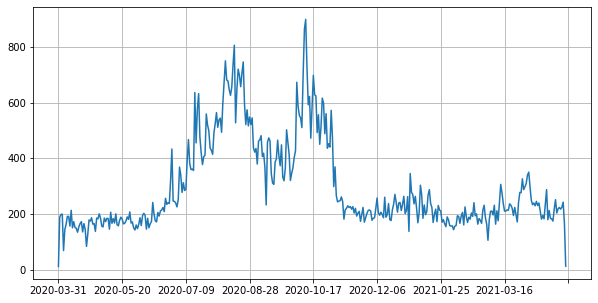

In [256]:
n_user_per_ma_ts.sum(axis=1).plot(figsize=(10,5), grid=True);

In [257]:
n_user_per_ma_ts.to_csv(os.path.join('data', 'mobility', 'twt_tour_flows.csv'))

### Map with the distribution of TWT posts

In [288]:
n_user_per_ma_ts= pd.read_csv(os.path.join('data', 'mobility', 'twt_tour_flows.csv'), index_col=0)
n_user_per_ma_ts.index= pd.to_datetime(n_user_per_ma_ts.index)

In [289]:
n_user_per_ma_ts.head()

,01001_AM,01002,01010_AM,01031_AM,01036,01043_AM,01047_AM,01051,01058_AM,01059,...,50240_AM,50251_AM,50252,50272,50288,50297,50298,50903_AM,51001,52001
2020-03-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-04-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2020-04-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2020-04-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-04-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0


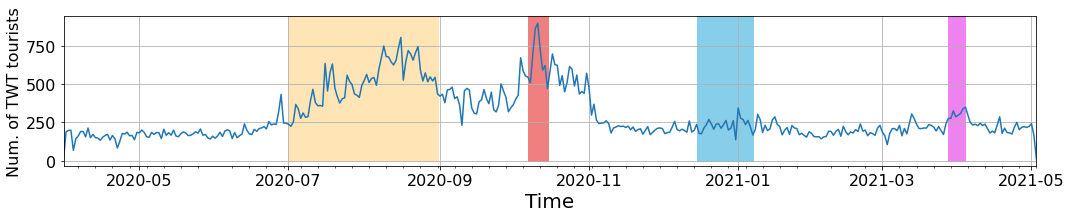

In [290]:
ax= n_user_per_ma_ts.sum(axis=1).plot(figsize=(15,3), grid=True, legend=False);
ax.set_xlabel('Time', fontsize=20)
ax.set_ylabel('Num. of TWT tourists', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
plt.ticklabel_format(style='plain', axis='y')

#Summer season
startTime = dt.strptime('01/07/2020', '%d/%m/%Y')
endTime = dt.strptime('31/08/2020', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='moccasin')
ax.add_patch(rect)

#October bank holiday
startTime = dt.strptime('07/10/2020', '%d/%m/%Y')
endTime = dt.strptime('15/10/2020', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='lightcoral')
ax.add_patch(rect)

#Christmas holiday
startTime = dt.strptime('15/12/2020', '%d/%m/%Y')
endTime = dt.strptime('07/01/2021', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='skyblue')
ax.add_patch(rect)

#Easter week holiday
startTime = dt.strptime('28/03/2021', '%d/%m/%Y')
endTime = dt.strptime('04/04/2021', '%d/%m/%Y')
start = mdates.date2num(startTime)
end = mdates.date2num(endTime)

width = end-start
rect = Rectangle((start, 0), width, 2000000, color='violet')
ax.add_patch(rect)


locator = mdates.AutoDateLocator(minticks=3)
formatter = mdates.AutoDateFormatter(locator)

ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.savefig(os.path.join('figs','ts_twt.png'))

In [291]:
def plot_autocorrelation(df, name='default'):
    plt.figure(figsize = (15,4))
    plt.grid(True)

    plt.grid(True)
    plt.xlabel("lags", fontsize = 24)
    plt.ylabel('correlation', fontsize = 24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=16)
    ax= sns.lineplot(data=df);
    #hide legend
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    plt.savefig(os.path.join('figs', f'autocorrelation_{name}.png'))

In [296]:
n_user_per_ma_ts.sum(axis=1)

2020-03-31     11.0
2020-04-01    188.0
2020-04-02    198.0
2020-04-03    199.0
2020-04-04     68.0
              ...  
2021-04-29    217.0
2021-04-30    224.0
2021-05-01    242.0
2021-05-02    165.0
2021-05-03     12.0
Length: 399, dtype: float64

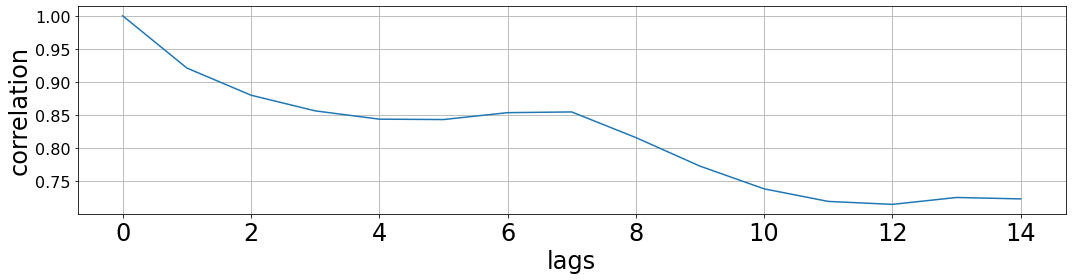

In [300]:
corr_values = spi.tsa.acf(n_user_per_ma_ts.sum(axis=1).values, nlags = 14,fft = False)
plot_autocorrelation(corr_values, 'twt')

In [267]:
twts_per_area= n_user_per_ma_ts.sum().to_frame()
twts_per_area.columns=['n_tweets']
twts_per_area = twts_per_area.reset_index()
twts_per_area.head()

,index,n_tweets
0,01001_AM,24.0
1,01002,8.0
2,01010_AM,14.0
3,01031_AM,95.0
4,01036,14.0


In [268]:
census_zones_gdf= gpd.read_file(os.path.join('data','agg_mun_tourist.geojson'),driver='GeoJSON')
census_zones_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803..."
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42..."
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362..."
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42..."
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658..."


In [270]:
twt_map_gdf = census_zones_gdf.merge(twts_per_area, left_on='primary_key', right_on='index')

In [271]:
twt_map_gdf.head()

,primary_key,area_km2,Viv-total,hotels-total,camps-total,POB20,HOMBRES,MUJERES,Viv-per-area,hotels-per-area,camps-per-area,geometry,index,n_tweets
0,01001_AM,359.212,17.0,4.0,1.0,7470,3945,3525,0.047326,0.011135,0.002784,"POLYGON ((-2.46644 42.78842, -2.46983 42.78803...",01001_AM,24.0
1,01002,96.348,8.0,1.0,1.0,10264,5044,5220,0.083032,0.010379,0.010379,"MULTIPOLYGON (((-2.97525 42.93816, -2.97702 42...",01002,8.0
2,01010_AM,197.821,17.0,0.0,0.0,5971,3021,2950,0.085936,0.000000,0.000000,"POLYGON ((-3.00076 43.06800, -3.00853 43.06362...",01010_AM,14.0
3,01031_AM,372.013,50.0,18.0,1.0,7428,3851,3577,0.134404,0.048385,0.002688,"MULTIPOLYGON (((-2.48257 42.49991, -2.48180 42...",01031_AM,95.0
4,01036,37.559,5.0,1.0,0.0,18118,8868,9250,0.133124,0.026625,0.000000,"POLYGON ((-2.93850 43.13864, -2.93541 43.13658...",01036,14.0


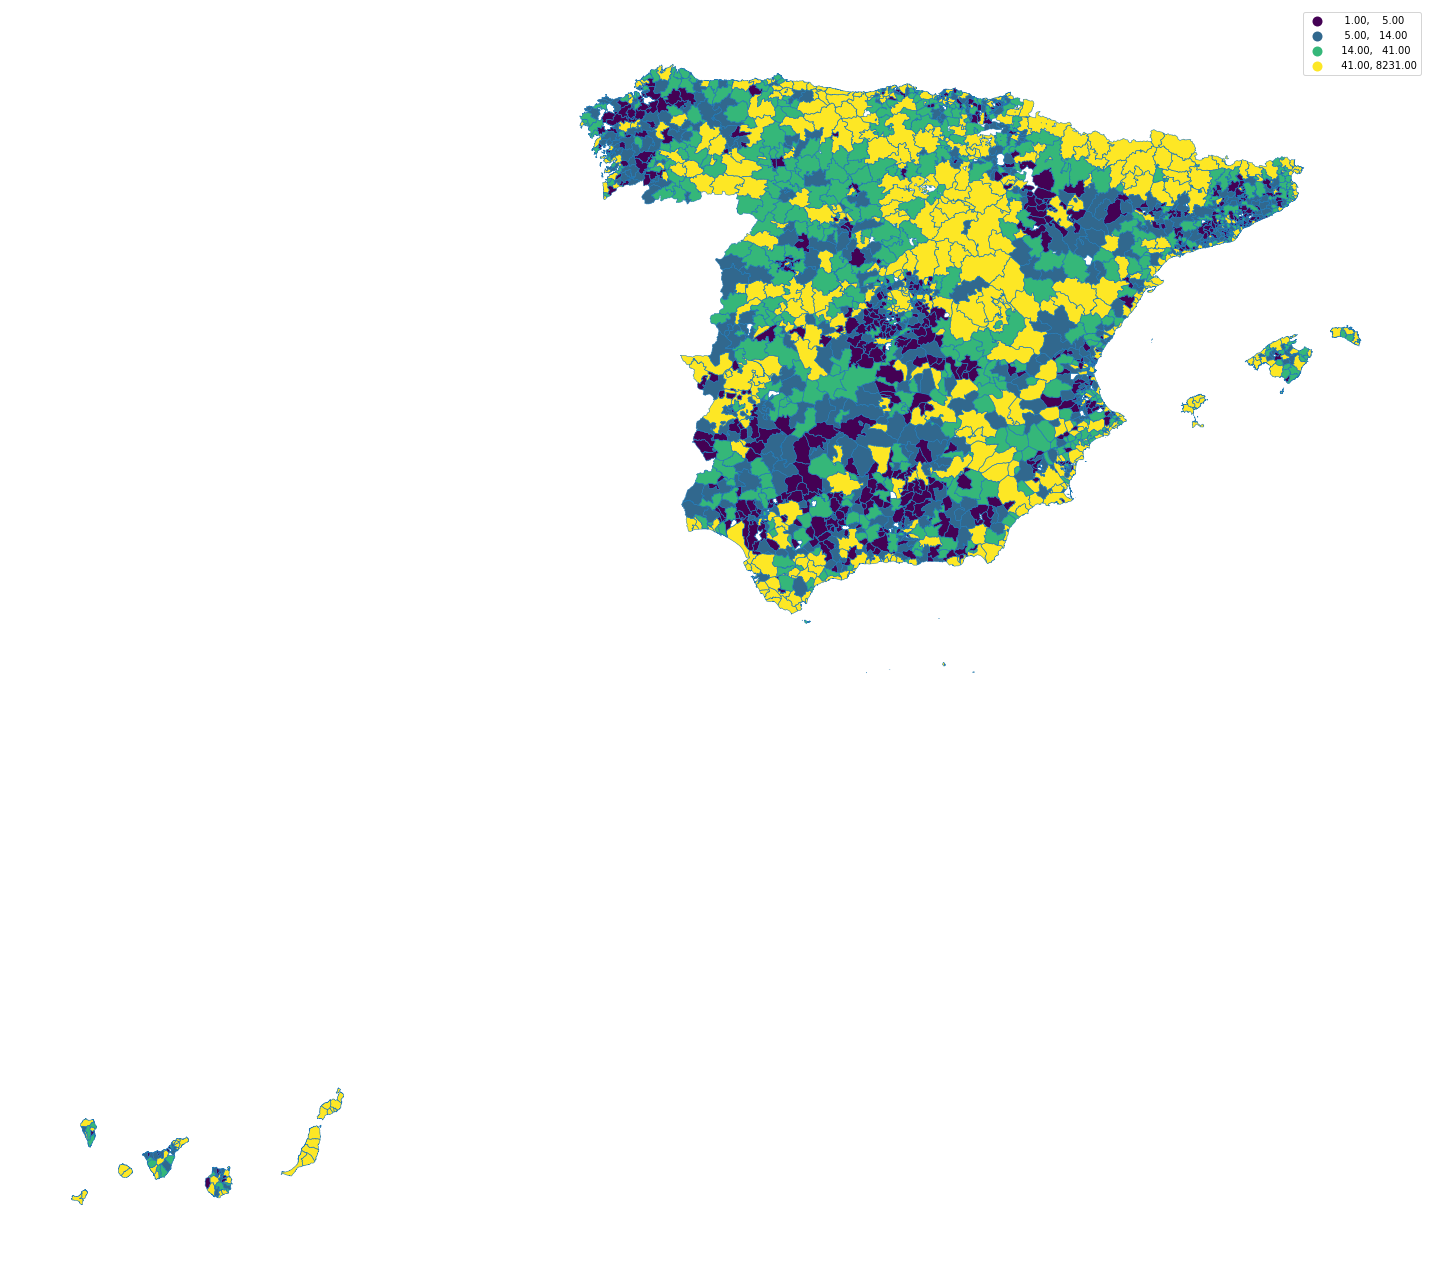

In [274]:
ax=census_zones_gdf.boundary.plot(figsize=(20,20),linewidth=0.5);
twt_map_gdf.plot('n_tweets',ax=ax, scheme='quantiles', legend=True, k=4);
ax.set_axis_off()
plt.tight_layout()
plt.savefig(os.path.join('figs','map_tweets.png'))

In [275]:
print("That's all folks!")

That's all folks!
